In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'ML_Colab_CS231/assignment1/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/My\ Drive
# %cp -r $FOLDERNAME ../../
# %cd ../../
# %cd cs231n/datasets/
%cd $FOLDERNAME/datasets/
!bash get_datasets.sh
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/ML_Colab_CS231/assignment1/cs231n/datasets
--2020-09-27 18:25:05--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  53.9MB/s    in 3.0s    

2020-09-27 18:25:08 (53.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/ML_Colab_CS231/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.332073
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 
Because the C=10 exp(scores) values are expected to be similar (since W was drawn from a small Gaussian) for every train sample 1...N.

So -1/N * sum( ln( exp(scores[y[n]])/sum(exp(scores)) ) ~ -1/N * N * ln( K/(10*K) ) = -ln(0.1)


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.174809 analytic: -3.174809, relative error: 1.775874e-09
numerical: 1.103583 analytic: 1.103582, relative error: 4.324088e-08
numerical: -1.266721 analytic: -1.266721, relative error: 4.118130e-09
numerical: -4.027635 analytic: -4.027635, relative error: 9.467347e-09
numerical: 0.612912 analytic: 0.612912, relative error: 2.649433e-08
numerical: 4.252159 analytic: 4.252159, relative error: 1.227686e-09
numerical: 3.333612 analytic: 3.333612, relative error: 2.492823e-08
numerical: -2.523876 analytic: -2.523876, relative error: 1.287018e-08
numerical: -4.162866 analytic: -4.162866, relative error: 7.360512e-09
numerical: -1.623092 analytic: -1.623093, relative error: 3.193456e-08
numerical: 1.797633 analytic: 1.797633, relative error: 3.285636e-08
numerical: 1.526062 analytic: 1.526062, relative error: 1.858701e-09
numerical: 3.661092 analytic: 3.661092, relative error: 1.347323e-08
numerical: -6.601355 analytic: -6.601355, relative error: 5.641303e-09
numerical: -0.138108

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.332073e+00 computed in 0.123338s
vectorized loss: 2.332073e+00 computed in 0.021980s
Loss difference: 0.000000
Gradient difference: 0.000000


In [10]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [3e-7, 1e-6]  # [1e-7, 5e-7]
regularization_strengths = [3e4, 1e5]  # [2.5e4, 5e4]

valed_lrs = np.logspace( np.log10(learning_rates[0]), np.log10(learning_rates[1]), num=5 )
valed_regs = np.logspace( np.log10(regularization_strengths[0]), np.log10(regularization_strengths[1]), num=5 )

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import itertools

for lr, reg in itertools.product(valed_lrs, valed_regs):
  from cs231n.classifiers import Softmax
  softmax = Softmax()
  softmax.train(X_train, y_train, lr, reg, num_iters=1500, batch_size=200)  # num_iters LCB 600 JARIASF 1500
  y_train_pred = softmax.predict(X_train)
  train_acc = np.sum(y_train_pred == y_train) / len(y_train)
  y_val_pred = softmax.predict(X_val)
  val_acc = np.sum(y_val_pred == y_val) / len(y_val)
  
  if val_acc > best_val:
    best_val = val_acc
    best_softmax = softmax

  results[(lr, reg)] = (train_acc, val_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 3.000000e-07 reg 3.000000e+04 train accuracy: 0.331102 val accuracy: 0.352000
lr 3.000000e-07 reg 4.053600e+04 train accuracy: 0.308143 val accuracy: 0.317000
lr 3.000000e-07 reg 5.477226e+04 train accuracy: 0.303673 val accuracy: 0.319000
lr 3.000000e-07 reg 7.400828e+04 train accuracy: 0.301265 val accuracy: 0.311000
lr 3.000000e-07 reg 1.000000e+05 train accuracy: 0.269531 val accuracy: 0.291000
lr 4.053600e-07 reg 3.000000e+04 train accuracy: 0.329224 val accuracy: 0.338000
lr 4.053600e-07 reg 4.053600e+04 train accuracy: 0.310571 val accuracy: 0.333000
lr 4.053600e-07 reg 5.477226e+04 train accuracy: 0.313612 val accuracy: 0.313000
lr 4.053600e-07 reg 7.400828e+04 train accuracy: 0.289204 val accuracy: 0.311000
lr 4.053600e-07 reg 1.000000e+05 train accuracy: 0.295490 val accuracy: 0.302000
lr 5.477226e-07 reg 3.000000e+04 train accuracy: 0.325531 val accuracy: 0.350000
lr 5.477226e-07 reg 4.053600e+04 train accuracy: 0.310735 val accuracy: 0.326000
lr 5.477226e-07 reg 5.477226

In [11]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.349000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
True.

$\color{blue}{\textit Your Explanation:}$
For the SVM (and thus hinge loss typically), a new training sample placed correctly and deep into the direction/place of its class, so that its class score (the correct one) is more than the margin above the scores of all the other classes, doesn't increment the total loss.

On the contrary, in the case of a softmax (and therefore a cross-entropy loss), even if again the training sample is placed deep into the direction of its class, the confidence of its class will be very close to but not 1, so the new addend in the total loss, -ln(confidence) of this new sample, will be very close to but greater than zero, therefore the total loss will be increased by a tiny bit.


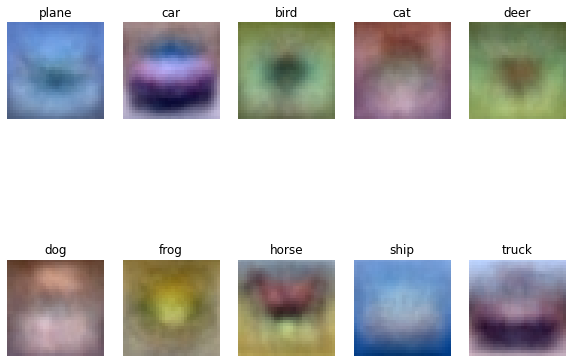

In [12]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [13]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['cs231n/classifiers/softmax.py']

#for files in FILES_TO_SAVE:
#  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
#    f.write(''.join(open(files).readlines()))